# MEPs in diseased vs healthy mice

In [2]:
from tqdm import tqdm
from mepextract.extracting import Extractor
from scipy.signal import find_peaks
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
import os
import pickle
import json

plt.style.use(['science', 'grid', 'custom', 'vibrant'])

## defining relevant folders and paths

In [14]:
excel = '/Users/fomo/Documents/Research/UNIC Research/Motor Evoked Potentials Test/MICE_LIST_EEG.xlsx'
temp = pd.read_excel(excel, sheet_name='MEP2024')
temp = temp.iloc[91:]

temp.to_csv('/Users/fomo/Documents/Research/UNIC Research/Motor Evoked Potentials Test/MICE_EEG_2024 (93-257).csv', index=False)

temp.head()

,session,animalID,cage,ear,phenotype,phenoCode,subrec,sessionClass,sessionType,currentLevel,stim_lvl,isoflo,trials_from,trials_to,notes
91,2024-03-07_18-03-10,A571,NaN,NaN,5XFAD,2.0,1.0,MEP,sciatic,1.49,thr,1.9,1.0,60,'A571 sciatic at threshold of 1.49mA 50us pulse'
92,2024-03-07_18-04-31,A571,NaN,NaN,5XFAD,2.0,1.0,MEP,sciatic,2.25,1.5x,1.9,1.0,60,'A571 sciatic at 1.5x thr 2.25mA 50us pulse'
93,2024-03-07_18-11-10,A571,NaN,NaN,5XFAD,2.0,1.0,MEP,spine_hump,2.25,thr,1.9,1.0,60,'A571 spine hump at thr 2.75mA 200us pulse'
94,2024-03-07_18-12-24,A571,NaN,NaN,5XFAD,2.0,1.0,MEP,spine_hump,4.12,1.5x,1.9,1.0,60,'A571 spine hump at 1.5xthr 4.12mA 200us pulse'
95,2024-03-07_18-26-03,A573,NaN,NaN,5XFAD,2.0,1.0,MEP,sciatic,3.37,thr,1.9,1.0,60,'A573 sciatic at 3.37mA 50us pulseA573 sciatic...


In [5]:
test = '/Users/fomo/Documents/Research/UNIC Research/Motor Evoked Potentials Test/MICE_EEG_2024 (93-102).csv'
full = '/Users/fomo/Documents/Research/UNIC Research/Motor Evoked Potentials Test/MICE_EEG_2024 (93-257).csv'

spreadsheet = pd.read_csv(full)

master_folder = '/Volumes/STORAGE 1.0/UNIC Research/Motor Evoked Potentials/MEPSSEP_raw_data/post 93'
test_folder = '/Users/fomo/Documents/Research/UNIC Research/Motor Evoked Potentials Test'


spreadsheet

,session,animalID,cage,ear,phenotype,phenoCode,subrec,sessionClass,sessionType,currentLevel,stim_lvl,isoflo,trials_from,trials_to,notes
0,2024-03-07_18-03-10,A571,NaN,NaN,5XFAD,2.0,1.0,MEP,sciatic,1.49,thr,1.9,1.0,60,'A571 sciatic at threshold of 1.49mA 50us pulse'
1,2024-03-07_18-04-31,A571,NaN,NaN,5XFAD,2.0,1.0,MEP,sciatic,2.25,1.5x,1.9,1.0,60,'A571 sciatic at 1.5x thr 2.25mA 50us pulse'
2,2024-03-07_18-11-10,A571,NaN,NaN,5XFAD,2.0,1.0,MEP,spine_hump,2.25,thr,1.9,1.0,60,'A571 spine hump at thr 2.75mA 200us pulse'
3,2024-03-07_18-12-24,A571,NaN,NaN,5XFAD,2.0,1.0,MEP,spine_hump,4.12,1.5x,1.9,1.0,60,'A571 spine hump at 1.5xthr 4.12mA 200us pulse'
4,2024-03-07_18-26-03,A573,NaN,NaN,5XFAD,2.0,1.0,MEP,sciatic,3.37,thr,1.9,1.0,60,'A573 sciatic at 3.37mA 50us pulseA573 sciatic...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,2024-03-09_17-48-26,A572,NaN,NaN,5XFAD,2.0,1.0,MEP,skull_needles,6.00,max,1.9,1.0,60,'A572 LECB skull 6mA 200us 5 pulses'
161,2024-03-09_17-53-55,A571,NaN,NaN,5XFAD,2.0,1.0,MEP,skull_needles,4.14,thr,1.9,1.0,60,'A571 RECB skull 4.14mA 200us 5 pulses'
162,2024-03-09_17-55-40,A571,NaN,NaN,5XFAD,2.0,1.0,MEP,skull_needles,6.20,1.5x,1.9,1.0,60,'A571 RECB skull 6.2mA 200us 5 pulses'
163,2024-03-09_18-06-40,A573,NaN,NaN,5XFAD,2.0,1.0,MEP,skull_needles,3.00,thr,1.9,1.0,60,'A573 thr skull 3mA 5 pulses 200usA573 thr sku...


## extracting MEPs for all trials

In [11]:
# number of trials to iterate over
n = len(spreadsheet)
sampling_rate = 30000

extracted = []

for i in tqdm(range(0, n), desc="Processing trials"):
    if spreadsheet['sessionType'][i] == 'reject':
        continue
    else:
        # relevant information
        trial = spreadsheet.session[i]
        notes = spreadsheet.loc[i]
        
        # defining extractor object
        extractor = Extractor(
            master_folder=master_folder , 
            trial=trial, 
            recording_channels=[5, 7],
            group=None,
            sampling_rate=sampling_rate)
        extractor.pre_stimulus = 300
        extractor.post_stimulus = 3000
        extractor.notes = notes
        
        # extracting relevant data
        extractor.extract_raw()
        extractor.extract_events(event_channel_number=13)
        extractor.get_event_data(export=False)
        
        detected = {'trial': trial, 'notes': notes, 'data': extractor.mep}
    
        extracted.append(detected)
    

Processing trials: 100%|██████████| 165/165 [01:17<00:00,  2.12it/s]


In [12]:
# saving extracted data
with open('/Users/fomo/Documents/Research/UNIC Research/Motor Evoked Potentials Test/extracted.pkl', 'wb') as f:
    pickle.dump(extracted, f)

In [3]:
# loading extracted data

extract_location = '/Users/fomo/Documents/Research/UNIC Research/Motor Evoked Potentials Test/extracted.pkl'

with open(extract_location, 'rb') as f:
    extracted = pickle.load(f)

## test code for first ten trials

In [39]:
detected_peaks_zone_1 = []
detected_peaks_zone_2 = []
detected_peaks_zone_3 = []

Processing trials: 100%|██████████| 3/3 [00:00<00:00, 150.36it/s]


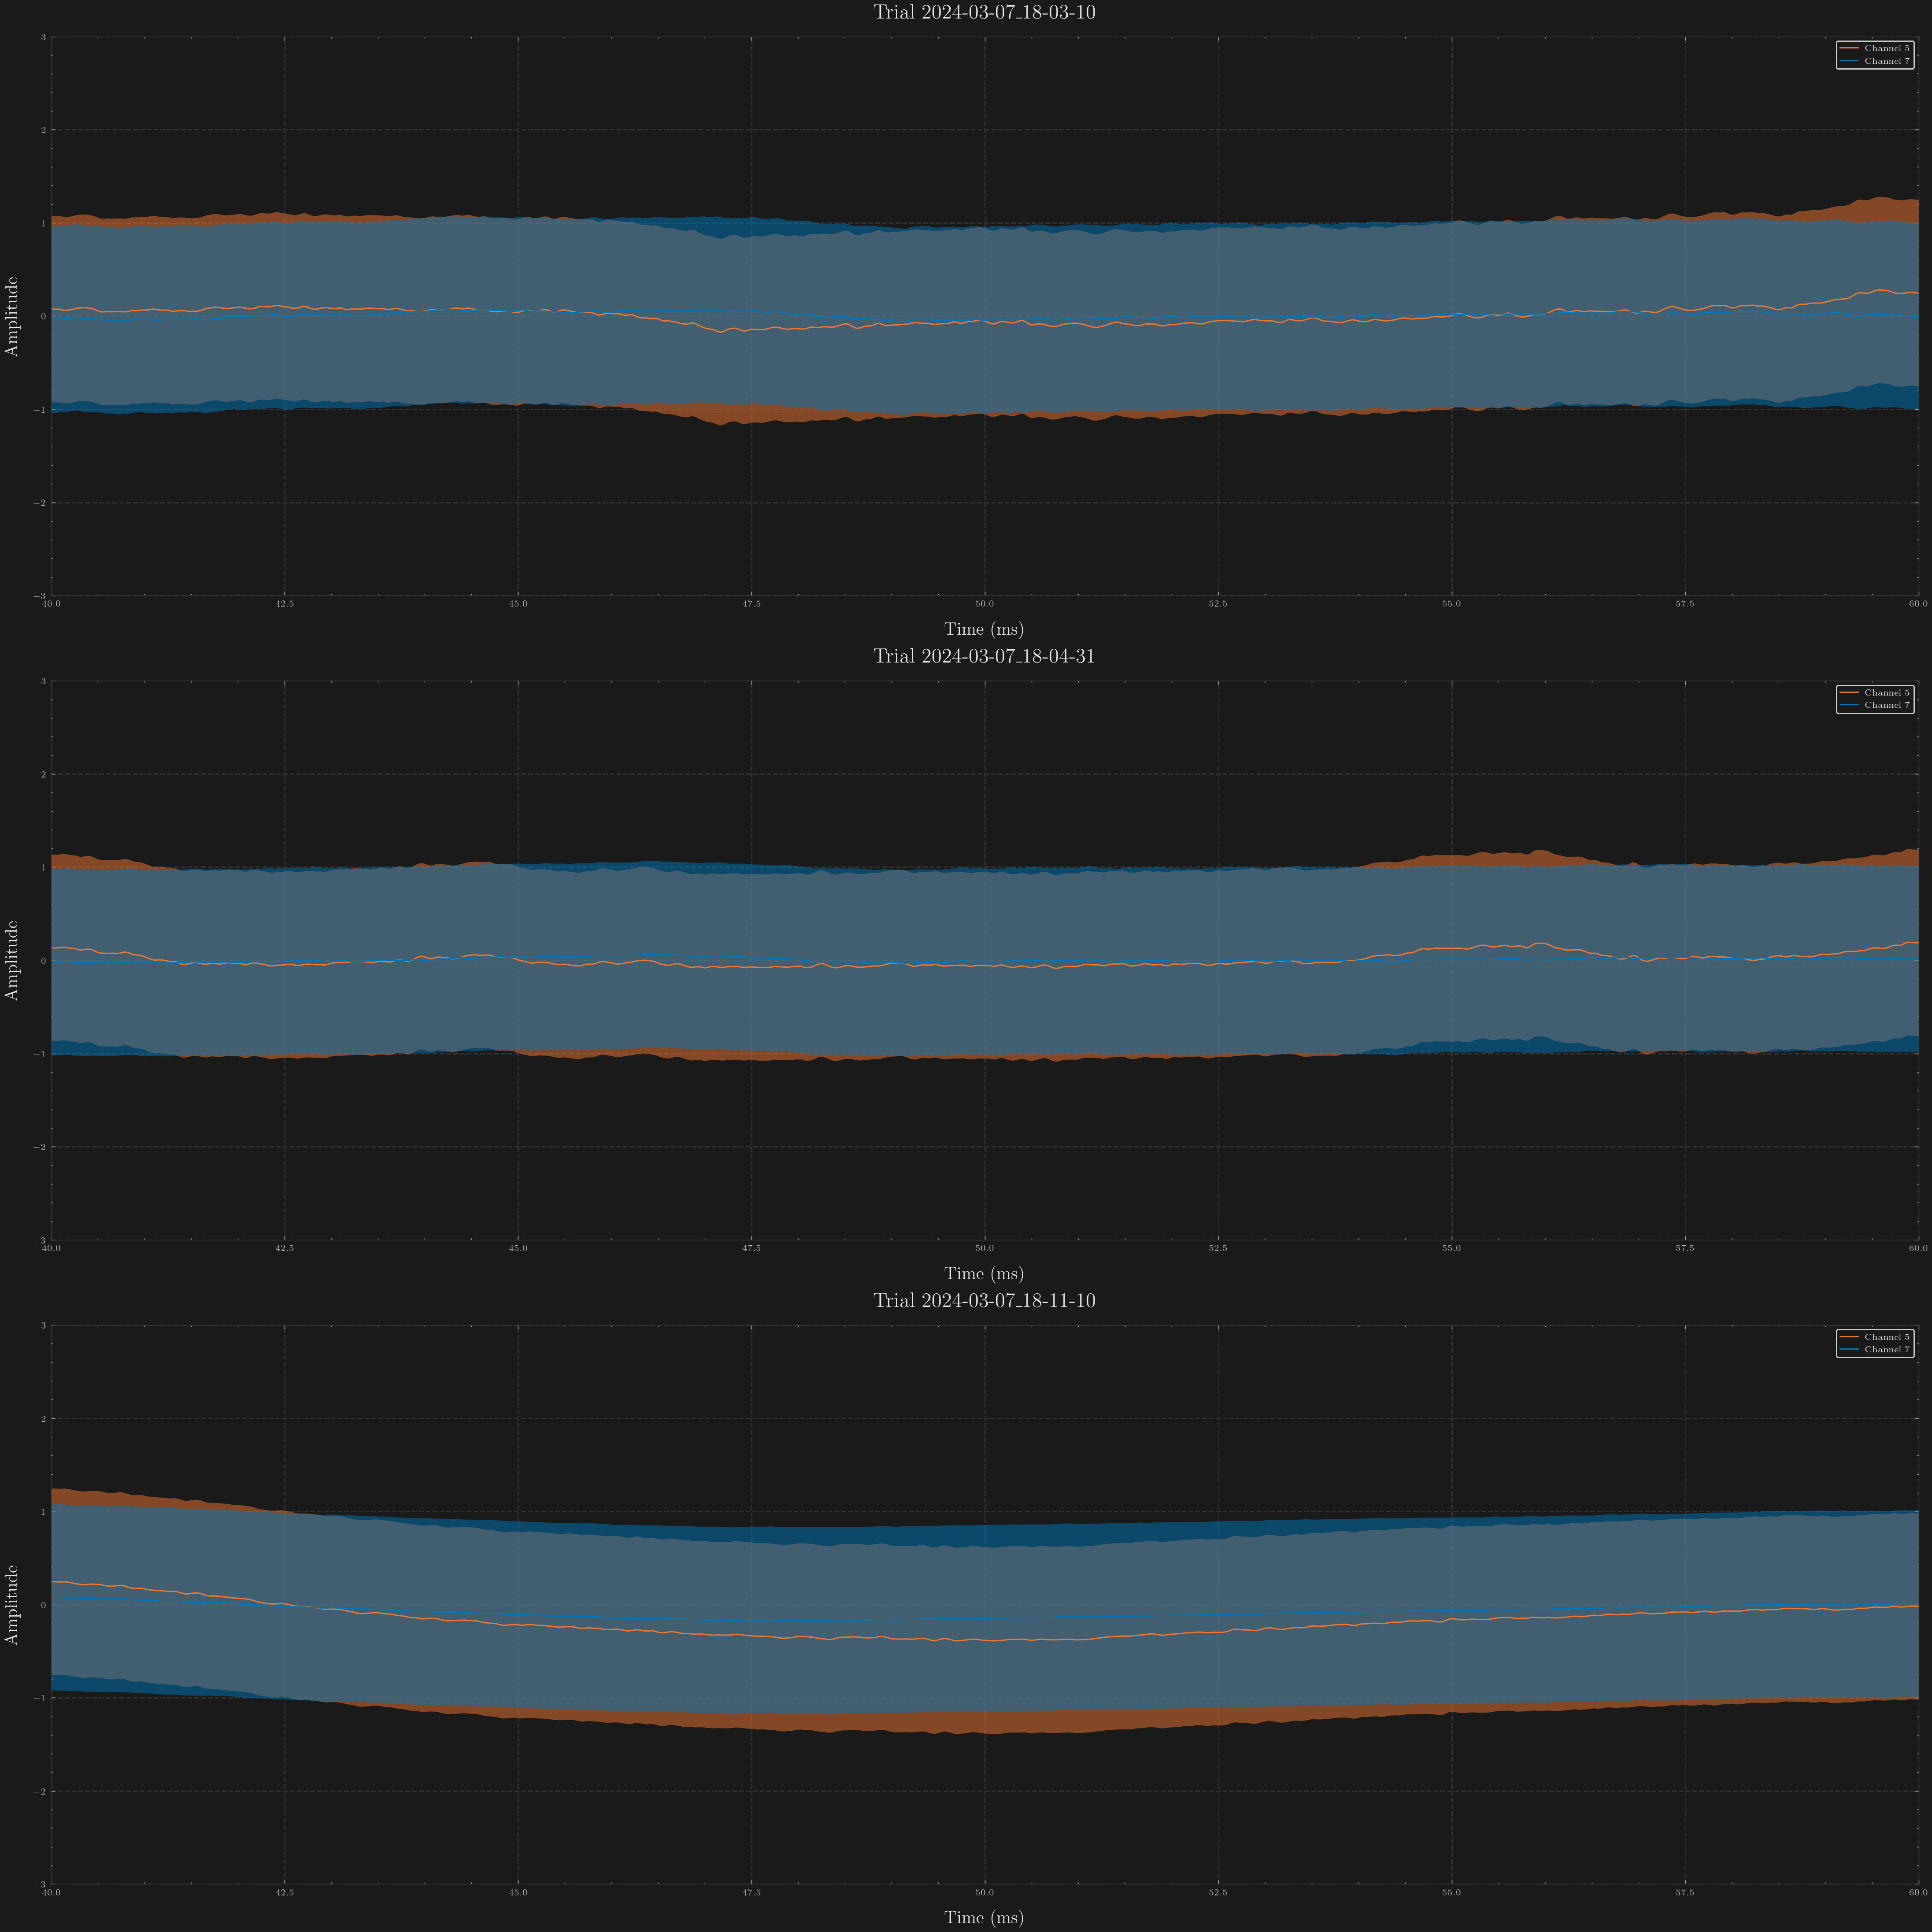

In [64]:
from scipy.ndimage import gaussian_filter1d as gf

sampling_rate = 30000

# defining relevant channels, peak parameters, time axis and current level
time_in_ms = np.arange(-300, 3000) * (1/sampling_rate * 1000)
recording_channels = [5, 7]
search = {'height': None ,'width': None, 'distance': None} # width = (0,50)

current_mean = spreadsheet['currentLevel'].mean()
current_std = spreadsheet['currentLevel'].std() 

# temporary data
n = 3

fig, ax = plt.subplots(n, 1, figsize=(21, 7*n), dpi=210)

for i in tqdm(range(n), desc="Processing trials"):
    
    temp = extracted[i]['data']
    current = extracted[i]['notes']['currentLevel']
    title = extracted[i]['notes']['session']
    group = int(extracted[i]['notes']['phenoCode'])

    delay = {'positive peaks': [], 'negative peaks': [], 'group': group, 'current': current}
    
    for channel in recording_channels:
        
        current = (current - current_mean)/current_std
        
        data = temp[channel, :, :]
        baseline = temp[channel, :10, :].mean(axis=1).mean(axis=0)
        correction = np.full((1, data.shape[0]), baseline)
        
        mean_events = (data.mean(axis=1)).flatten()
        std_events = (data.std(axis=1)).flatten()
        
        smoothed_mean = gf(mean_events, sigma=1.25)
        smoothed_std = gf(std_events, sigma=1.25)
        
        standardised = (1/current)*(smoothed_mean - smoothed_mean.mean())/smoothed_mean.std()
        
        pos_peaks, pos_parameters = find_peaks(standardised, height = search['height'], distance = search['distance'], width = search['width'])
        
        neg_peaks, neg_parameters = find_peaks(-standardised, height = search['height'], distance = search['distance'], width = search['width'])
        
        for peak in pos_peaks:
            if 330 < peak < 3000 and standardised[peak] > 1:
                ax[i].plot(time_in_ms[peak], standardised[peak], 'x', color='red')
                amplitude = standardised[peak]
                delay['positive peaks'].append((peak, amplitude))
        
        for peak in neg_peaks:
            if 330 < peak < 3000 and standardised[peak] < -1:
                ax[i].plot(time_in_ms[peak], standardised[peak], 'x', color='blue')
                amplitude = standardised[peak]
                delay['negative peaks'].append((peak, np.abs(amplitude)))
                
        detected_peaks_zone_1.append(delay)
        
        ax[i].plot(time_in_ms, standardised, label=f'Channel {channel}')
        ax[i].fill_between(time_in_ms, standardised - 1, standardised + 1, alpha=0.5)

        ax[i].set_title(f'Trial {title}', fontsize=16)
        ax[i].set_ylim(-3, 3)
        ax[i].set_xlim(40, 60)
        ax[i].set_xlabel('Time (ms)', fontsize=14)
        ax[i].set_ylabel('Amplitude', fontsize=14)
        ax[i].legend()

plt.tight_layout()
plt.savefig('/Users/fomo/Desktop/45to55ms(first_ten_trials).png')
plt.show()


## plotting delays

In [43]:
with open('/Users/fomo/Documents/Research/UNIC Research/Motor Evoked Potentials Test/zone_one.pkl', 'wb') as f:
    pickle.dump(detected_peaks_zone_1, f)

In [ ]:
with open('/Users/fomo/Documents/Research/UNIC Research/Motor Evoked Potentials Test/zone_two.pkl', 'wb') as f:
    pickle.dump(detected_peaks_zone_2, f)

In [ ]:
with open('/Users/fomo/Documents/Research/UNIC Research/Motor Evoked Potentials Test/zone_three.pkl', 'wb') as f:
    pickle.dump(detected_peaks_zone_3, f)

In [23]:
selected_peaks = []

for trial in detected_peaks:
    
    group = trial['group']
    current = trial['current']
    
    positive_peaks = (sorted(trial['positive peaks'], key=lambda x: x[0]))
    negative_peaks = (sorted(trial['negative peaks'], key=lambda x: x[0]))
    
    if len(positive_peaks) > 0 and len(negative_peaks) > 0:
        selected_peaks.append({'group': group, 'current': current, 'first positive peak': positive_peaks[0], 'first negative peak': negative_peaks[0]})
    
len(selected_peaks)
    

242

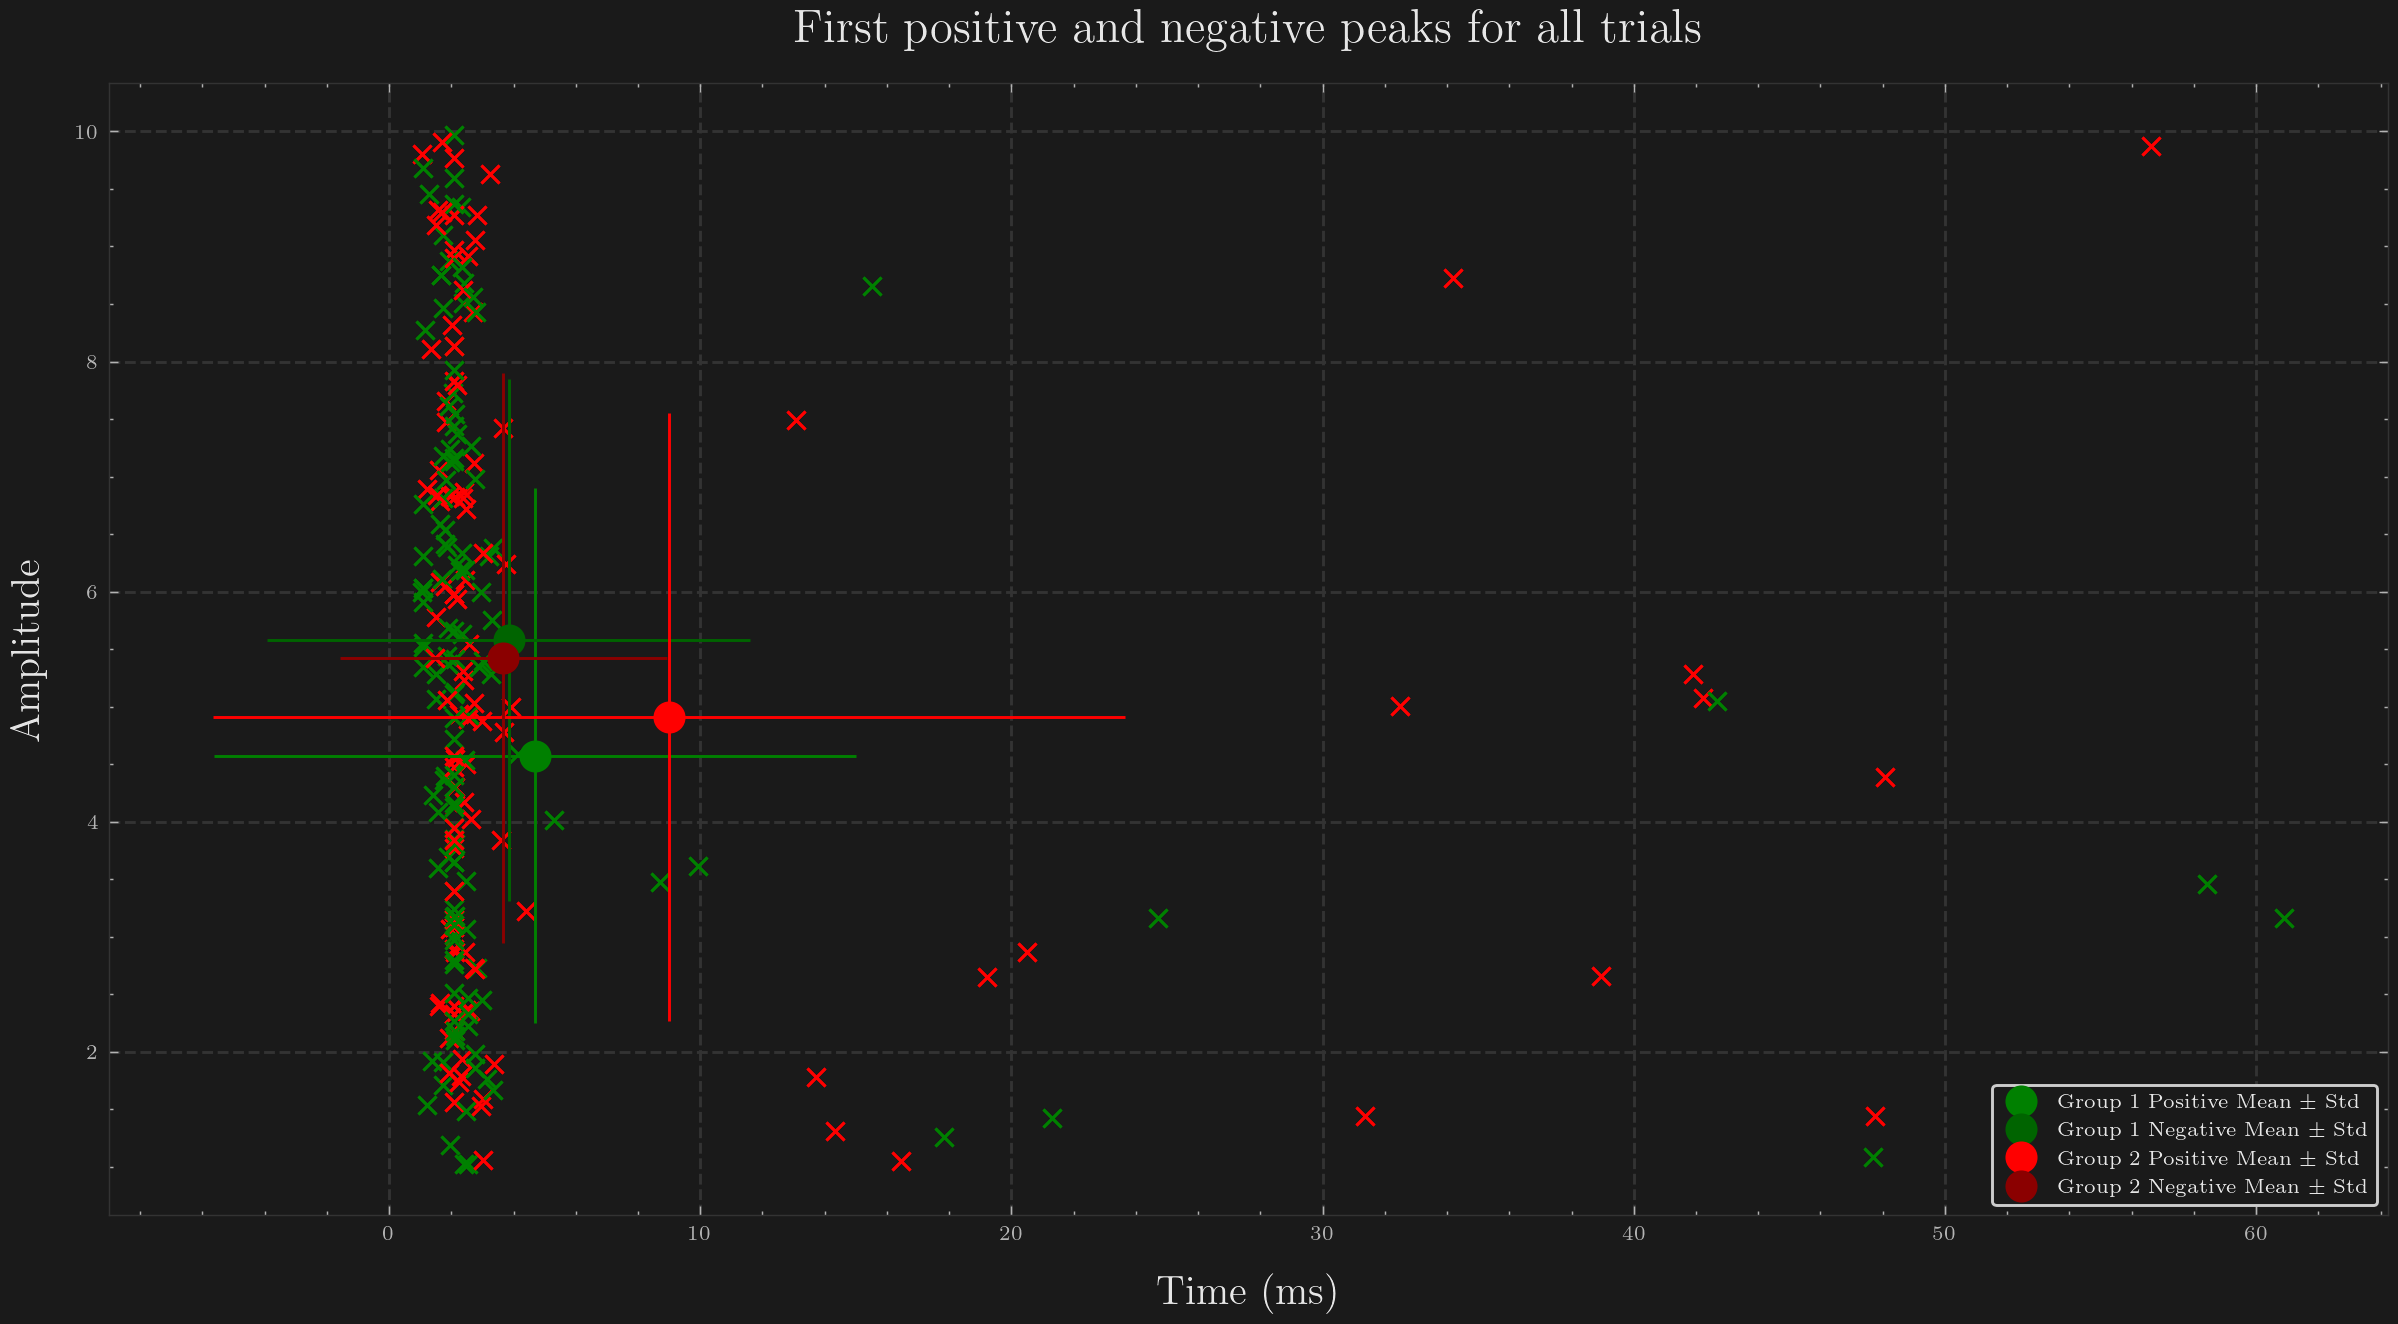

In [60]:
plt.figure(figsize=(14, 7), dpi=210)

conversion = (1 / sampling_rate) * 1000

# Helper function to determine color
def color_map(group):
    if group == 1:
        return 'green'
    else:
        return 'red'

# Lists to collect peaks by group for calculating mean and std dev in both dimensions
group1_positive_peaks = []
group1_negative_peaks = []
group2_positive_peaks = []
group2_negative_peaks = []

# Loop through peaks and plot individual points
for peak in selected_peaks:
    time_pos_peak = peak['first positive peak'][0] * conversion - 10
    amp_pos_peak = peak['first positive peak'][1]
    time_neg_peak = peak['first negative peak'][0] * conversion - 10
    amp_neg_peak = peak['first negative peak'][1]

    # Add data to lists for calculating statistics later
    if peak['group'] == 1:
        group1_positive_peaks.append([time_pos_peak, amp_pos_peak])
        group1_negative_peaks.append([time_neg_peak, amp_neg_peak])
    else:
        group2_positive_peaks.append([time_pos_peak, amp_pos_peak])
        group2_negative_peaks.append([time_neg_peak, amp_neg_peak])

    # Plot individual points
    plt.plot(time_pos_peak, amp_pos_peak, 'x', color=color_map(peak['group']))
    plt.plot(time_neg_peak, amp_neg_peak, 'x', color=color_map(peak['group']))

# Convert lists to numpy arrays for easier mean and std calculations
group1_positive_peaks = np.array(group1_positive_peaks)
group1_negative_peaks = np.array(group1_negative_peaks)
group2_positive_peaks = np.array(group2_positive_peaks)
group2_negative_peaks = np.array(group2_negative_peaks)

# Calculate means and standard deviations for both time and amplitude
if len(group1_positive_peaks) > 0:
    mean_group1_pos = np.mean(group1_positive_peaks, axis=0)
    std_group1_pos = np.std(group1_positive_peaks, axis=0)
    mean_group1_neg = np.mean(group1_negative_peaks, axis=0)
    std_group1_neg = np.std(group1_negative_peaks, axis=0)

    # Plot mean and standard deviation as error bars in both dimensions for Group 1 (green)
    plt.errorbar(mean_group1_pos[0], mean_group1_pos[1], xerr=std_group1_pos[0], yerr=std_group1_pos[1],
                 fmt='o', color='green', markersize=10, label='Group 1 Positive Mean ± Std')
    plt.errorbar(mean_group1_neg[0], mean_group1_neg[1], xerr=std_group1_neg[0], yerr=std_group1_neg[1],
                 fmt='o', color='darkgreen', markersize=10, label='Group 1 Negative Mean ± Std')

if len(group2_positive_peaks) > 0:
    mean_group2_pos = np.mean(group2_positive_peaks, axis=0)
    std_group2_pos = np.std(group2_positive_peaks, axis=0)
    mean_group2_neg = np.mean(group2_negative_peaks, axis=0)
    std_group2_neg = np.std(group2_negative_peaks, axis=0)

    # Plot mean and standard deviation as error bars in both dimensions for Group 2 (red)
    plt.errorbar(mean_group2_pos[0], mean_group2_pos[1], xerr=std_group2_pos[0], yerr=std_group2_pos[1],
                 fmt='o', color='red', markersize=10, label='Group 2 Positive Mean ± Std')
    plt.errorbar(mean_group2_neg[0], mean_group2_neg[1], xerr=std_group2_neg[0], yerr=std_group2_neg[1],
                 fmt='o', color='darkred', markersize=10, label='Group 2 Negative Mean ± Std')

# Add title and labels
plt.title('First positive and negative peaks for all trials', fontsize=16)
plt.xlabel('Time (ms)', fontsize=14)
plt.ylabel('Amplitude', fontsize=14)
plt.legend()
plt.savefig('/Users/fomo/Desktop/first_peaks.png')
plt.show()



In [66]:
from scipy.stats import ttest_ind, mannwhitneyu

# Assuming the peak data is already collected in group1_positive_peaks, group1_negative_peaks, etc.

# Group all the delays (zeroth index)
group1_delays = np.concatenate([group1_positive_peaks[:, 0], group1_negative_peaks[:, 0]])
group2_delays = np.concatenate([group2_positive_peaks[:, 0], group2_negative_peaks[:, 0]])

# Check if data are normally distributed using Shapiro-Wilk test
from scipy.stats import shapiro

shapiro_group1 = shapiro(group1_delays)
shapiro_group2 = shapiro(group2_delays)

print("Shapiro-Wilk test for Group 1 Delays: p-value =", shapiro_group1.pvalue)
print("Shapiro-Wilk test for Group 2 Delays: p-value =", shapiro_group2.pvalue)

# Determine if the data is normally distributed based on p-value > 0.05
if shapiro_group1.pvalue > 0.05 and shapiro_group2.pvalue > 0.05:
    # If data are approximately normal, use independent samples t-test
    t_stat, p_value = ttest_ind(group1_delays, group2_delays, equal_var=False)  # Welch's t-test
    print("Independent t-test p-value:", p_value)
else:
    # If data are not normally distributed, use Mann-Whitney U test
    u_stat, p_value = mannwhitneyu(group1_delays, group2_delays, alternative='two-sided')
    print("Mann-Whitney U test p-value:", p_value)

# Apply Bonferroni correction if performing multiple comparisons
alpha = 0.05  # Original significance level

# Since this is only one comparison, Bonferroni correction might not be needed here
# Compare p-value to alpha to determine significance
if p_value < alpha:
    print("The difference in delays between Group 1 and Group 2 is statistically significant.")
else:
    print("No statistically significant difference in delays between Group 1 and Group 2.")


Shapiro-Wilk test for Group 1 Delays: p-value = 1.1231865449225609e-30
Shapiro-Wilk test for Group 2 Delays: p-value = 2.407174539617314e-25
Mann-Whitney U test p-value: 0.00016322363125517294
The difference in delays between Group 1 and Group 2 is statistically significant.
